# Sobre o Dataset

O dataset **Chest X-Ray Images (Pneumonia)** cont√©m imagens de radiografias tor√°cicas de pacientes, sendo amplamente utilizado para tarefas de classifica√ß√£o de pneumonia com aprendizado de m√°quina.

- üìä **Total de imagens:** 5.863
- üìÅ **Divis√£o em conjuntos:** treino (`train`), valida√ß√£o (`val`) e teste (`test`)
- ü©ª **Classes:**
  - `NORMAL` ‚Äì pulm√µes saud√°veis
  - `PNEUMONIA` ‚Äì pulm√µes com infec√ß√£o (bacteriana ou viral)
- üß† **Objetivo:** treinar modelos de IA para detectar pneumonia com base em exames de raio-X.
- üîó **Fonte:** https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## 1. Importa√ß√£o das Bibliotecas

In [1]:
import kagglehub
from tensorflow.keras.utils import img_to_array
import shutil
import hashlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import random
import itertools
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.layers import GlobalAveragePooling2D

sns.set(style='whitegrid') # Define o estilo visual dos gr√°ficos do Seaborn com grade branca de fundo

Importa√ß√£o das bibliotecas utilizadas para manipula√ß√£o de imagens, divis√£o dos dados, constru√ß√£o e avalia√ß√£o da CNN, al√©m de visualiza√ß√£o de gr√°ficos e data augmentation.

### Caso esteja rodando pela 2¬™ vez - limpa a pasta, caso seja a 1¬™ - N√£o rodar

In [18]:
# Caminho da pasta de destino
dst_dir = './chest_xray'

# üîÅ Apaga a pasta se ela j√° existir (limpeza total antes de copiar)
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)
    print("üßπ Pasta antiga removida.")

# Agora copia novamente os dados do Kaggle
src_dir = os.path.join(path, 'chest_xray')  # ou s√≥ `path` se n√£o houver subpasta

if not os.path.exists(src_dir):
    print(f"‚ö†Ô∏è Subpasta 'chest_xray' n√£o encontrada dentro de {path}.")
    print("Conte√∫do encontrado:", os.listdir(path))
    src_dir = path

shutil.copytree(src_dir, dst_dir)
print("‚úÖ Dados copiados novamente do zero.")


üßπ Pasta antiga removida.
‚úÖ Dados copiados novamente do zero.


## üîç 1.1 Carregamento dos Dados

In [2]:
# Download do conjunto de dados do kaggle

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")  # Baixa o dataset de raio-X de pneumonia do Kaggle
print("Path to dataset files:", path)  # Exibe o caminho onde os arquivos foram salvos localmente


Path to dataset files: C:\Users\Bruna\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


Download do dataset de imagens de raio-X com pneumonia diretamente do Kaggle, usando a biblioteca kagglehub. O caminho de download √© exibido para facilitar o uso posterior.

In [3]:
## Copia dos Dados para o Diret√≥rio de Trabalho

# Define os caminhos
src_dir = os.path.join(path, 'chest_xray')  # pasta principal dentro do dataset
dst_dir = './chest_xray'  # destino no diret√≥rio de trabalho atual

# Verifica se a subpasta "chest_xray" realmente existe dentro de `path`
if not os.path.exists(src_dir):
    print(f"‚ö†Ô∏è Subpasta 'chest_xray' n√£o encontrada dentro de {path}. Listando conte√∫do:")
    print(os.listdir(path))
    # Se a pasta 'chest_xray' n√£o existir, use `path` diretamente
    src_dir = path

# Copia a pasta completa para o diret√≥rio atual
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"‚úÖ Dados copiados para o diret√≥rio de trabalho: {dst_dir}")


‚úÖ Dados copiados para o diret√≥rio de trabalho: ./chest_xray


C√≥pia do dataset para o diret√≥rio de trabalho, garantindo que os arquivos estejam acess√≠veis para o restante do processamento.

In [4]:
# Defini√ß√£o do diret√≥rio base

base_dir = dst_dir

Define o diret√≥rio base onde est√£o as imagens que ser√£o processadas e utilizadas nos modelos.

## üßπ 2. Limpeza e Padroniza√ß√£o das Imagens

In [5]:
# üìä CONTAGEM DE IMAGENS POR CONJUNTO E CLASSE

def contar_imagens(diretorio):
    dados = []
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos: treino, valida√ß√£o e teste
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as classes: NORMAL e PNEUMONIA
            caminho = os.path.join(diretorio, subset, classe)  # Monta o caminho completo da pasta da classe
            # Conta apenas os arquivos com extens√£o de imagem
            total = len([f for f in os.listdir(caminho) if f.endswith(('jpg', 'jpeg', 'png'))])
            # Armazena os dados em formato de dicion√°rio
            dados.append({'Conjunto': subset, 'Classe': classe, 'Total': total})
    return pd.DataFrame(dados)  # Retorna um DataFrame com as informa√ß√µes

df_contagem = contar_imagens(base_dir)  # Aplica a fun√ß√£o ao diret√≥rio base
display(df_contagem)  # Exibe a tabela resultante com a contagem de imagens por conjunto e classe


Conjunto     Classe  Total
0    train     NORMAL   1341
1    train  PNEUMONIA   3875
2      val     NORMAL      8
3      val  PNEUMONIA      8
4     test     NORMAL    234
5     test  PNEUMONIA    390

Contagem de imagens por classe e conjunto (train, val, test). A fun√ß√£o percorre as pastas e contabiliza a quantidade de imagens para cada categoria (NORMAL e PNEUMONIA), organizando os dados em uma tabela com o total por grupo.

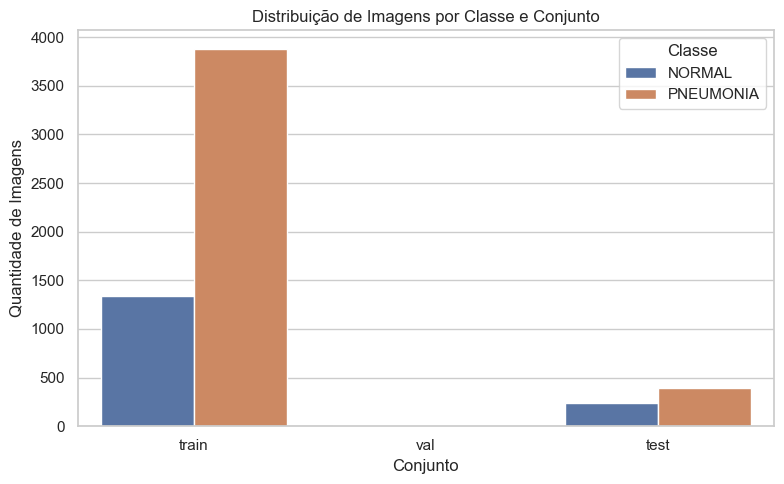

In [6]:
# üìà VISUALIZA√á√ÉO DA DISTRIBUI√á√ÉO DAS IMAGENS

plt.figure(figsize=(8, 5))  # Define o tamanho da figura (largura=8, altura=5)
sns.barplot(data=df_contagem, x='Conjunto', y='Total', hue='Classe')  # Cria um gr√°fico de barras agrupadas por classe e conjunto
plt.title('Distribui√ß√£o de Imagens por Classe e Conjunto')  # T√≠tulo do gr√°fico
plt.ylabel('Quantidade de Imagens')  # R√≥tulo do eixo Y
plt.xlabel('Conjunto')  # R√≥tulo do eixo X
plt.legend(title='Classe')  # Adiciona legenda com t√≠tulo 'Classe'
plt.tight_layout()  # Ajusta o layout para evitar sobreposi√ß√£o
plt.show()  # Exibe o gr√°fico


Visualiza√ß√£o da distribui√ß√£o das imagens por classe (NORMAL e PNEUMONIA) e por conjunto (train, val, test), evidenciando o desbalanceamento nos dados de treino.

### 2.1 Verifica√ß√£o de formatos e canais

In [7]:
# üîé VERIFICA√á√ÉO DOS FORMATOS DAS IMAGENS

def checar_formatos(diretorio):
    formatos = set()  # Conjunto para armazenar combina√ß√µes √∫nicas de tamanho e modo de cor das imagens
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos do dataset
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as duas classes
            pasta = os.path.join(diretorio, subset, classe)  # Caminho da pasta da classe
            for arquivo in os.listdir(pasta):  # Itera sobre os arquivos na pasta
                caminho = os.path.join(pasta, arquivo)  # Caminho completo da imagem
                try:
                    img = Image.open(caminho)  # Abre a imagem com PIL
                    formatos.add((img.size, img.mode))  # Adiciona o tamanho e o modo de cor (RGB, L, etc.) ao conjunto
                except:
                    continue  # Ignora arquivos corrompidos ou inv√°lidos
    return formatos  # Retorna o conjunto de formatos √∫nicos encontrados

formatos = checar_formatos(base_dir)  # Aplica a fun√ß√£o ao diret√≥rio base
print("Formatos √∫nicos encontrados:", formatos)  # Exibe os tamanhos e modos √∫nicos das imagens


Formatos √∫nicos encontrados: {((1426, 1052), 'L'), ((992, 680), 'L'), ((1152, 688), 'L'), ((1504, 1283), 'L'), ((1592, 1329), 'L'), ((1882, 1480), 'L'), ((1160, 897), 'L'), ((2164, 1746), 'L'), ((1518, 1121), 'L'), ((1360, 1208), 'L'), ((1360, 832), 'L'), ((824, 472), 'L'), ((1296, 920), 'L'), ((1200, 824), 'L'), ((869, 553), 'RGB'), ((1816, 1550), 'L'), ((1974, 1226), 'L'), ((1754, 1615), 'L'), ((984, 544), 'L'), ((1384, 792), 'L'), ((1784, 1216), 'L'), ((1666, 1333), 'L'), ((1604, 1179), 'L'), ((1448, 880), 'L'), ((1592, 1312), 'L'), ((1192, 688), 'L'), ((1736, 1424), 'L'), ((1088, 800), 'L'), ((1460, 1067), 'L'), ((1688, 1120), 'L'), ((1312, 832), 'L'), ((1738, 1296), 'L'), ((1686, 1133), 'L'), ((1808, 1488), 'L'), ((1560, 1200), 'L'), ((1128, 680), 'L'), ((1534, 1064), 'L'), ((1632, 1186), 'L'), ((1224, 976), 'L'), ((1288, 800), 'L'), ((1164, 735), 'L'), ((1192, 992), 'L'), ((735, 467), 'RGB'), ((1978, 1777), 'L'), ((1088, 728), 'L'), ((1944, 1367), 'L'), ((1812, 1627), 'L'), ((17

Verifica√ß√£o dos formatos das imagens, listando combina√ß√µes √∫nicas de tamanho e modo de cor (como 'L' para escala de cinza e 'RGB' para colorido). Isso garante que os dados tenham formato consistente antes do treino.

### 2.2 Fun√ß√£o de limpeza (convers√£o, remo√ß√£o, hashing)

In [8]:
def imagem_pequena(img, min_size=(100, 100)):
    return img.size[0] < min_size[0] or img.size[1] < min_size[1]

Verifica se a imagem √© pequena, ou seja, se tem largura ou altura menor que o m√≠nimo definido (100x100). Serve para remover imagens com baixa resolu√ß√£o.

In [9]:
def imagem_duplicada(img, hash_set):
    hash_val = hashlib.md5(img.tobytes()).hexdigest()
    if hash_val in hash_set:
        return True
    hash_set.add(hash_val)
    return False

Detecta imagens duplicadas usando um hash gerado a partir dos bytes da imagem. Se o hash j√° estiver no conjunto, a imagem √© considerada repetida e pode ser descartada.

In [10]:
USE_GRAYSCALE = True

def converter_para_cinza(img):
    if USE_GRAYSCALE:
        return img.convert('L')
    else:
        return img.convert('RGB')

Converte a imagem para escala de cinza ('L') se a vari√°vel USE_GRAYSCALE estiver ativada. Caso contr√°rio, mant√©m em modo RGB (colorido).

In [11]:
def limpar_e_padronizar_imagens(base_dir):
    hash_set = set()
    total_removidas = 0
    total_convertidas = 0

    print("üßº Iniciando limpeza e convers√£o das imagens...")

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                print(f"‚ö†Ô∏è Pasta n√£o encontrada: {path}")
                continue

            files = os.listdir(path)
            print(f"\nüìÇ Processando {subset}/{classe} ‚Äì {len(files)} arquivos")

            for file in files:
                file_path = os.path.join(path, file)

                try:
                    img = Image.open(file_path)

                    if imagem_pequena(img):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"üóëÔ∏è Removida (pequena): {file}")
                        continue

                    img = converter_para_cinza(img)

                    if imagem_duplicada(img, hash_set):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"üóëÔ∏è Removida (duplicada): {file}")
                        continue

                    img.save(file_path)
                    total_convertidas += 1
                    print(f"‚úÖ Convertida para escala de cinza: {file}")

                except Exception as e:
                    os.remove(file_path)
                    total_removidas += 1
                    print(f"‚ùå Erro ao processar {file}: {e}")

    print("\nüìä Etapa de limpeza finalizada!")
    print(f"üóëÔ∏è Total de imagens removidas: {total_removidas}")
    print(f"‚úÖ Total convertidas e salvas: {total_convertidas}")

    # üîß Aplica o redimensionamento final ap√≥s limpeza
    print("\nüìê Iniciando redimensionamento para tamanho padr√£o...")


 Fun√ß√£o de limpeza e padroniza√ß√£o das imagens. Remove imagens pequenas ou duplicadas, converte para escala de cinza e salva novamente no mesmo local. Ao final, imprime um resumo da quantidade de imagens removidas e convertidas.

In [14]:
def redimensionar_imagens(base_dir, target_size=(128, 128)):
    total_redimensionadas = 0
    erros = 0

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                continue

            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                try:
                    img = Image.open(file_path)
                    img = img.resize(target_size)
                    img.save(file_path)
                    total_redimensionadas += 1
                except Exception as e:
                    erros += 1
                    print(f"‚ùå Erro ao redimensionar {file}: {e}")

    print(f"‚úÖ Total redimensionadas: {total_redimensionadas}")
    print(f"‚ùå Erros: {erros}")


Redimensiona todas as imagens do dataset para o tamanho padr√£o de 128√ó128 pixels, garantindo uniformidade na entrada da rede neural. Tamb√©m contabiliza o total de imagens processadas e eventuais erros.

In [15]:
redimensionar_imagens(base_dir, target_size=(128, 128))

‚úÖ Total redimensionadas: 5856
‚ùå Erros: 0


Execu√ß√£o da fun√ß√£o de redimensionamento: todas as 5.856 imagens foram redimensionadas com sucesso para 128√ó128 pixels, sem erros.

## üìä 2.1 Duplicando os dados

In [16]:
def triplicar_744_validas_com_3_copias(base_dir):
    normal_dir = os.path.join(base_dir, 'train', 'NORMAL')

    # Remove duplicatas anteriores
    for arquivo in os.listdir(normal_dir):
        if arquivo.startswith("dup_"):
            os.remove(os.path.join(normal_dir, arquivo))
    print("üßπ Duplicatas antigas removidas.")

    # Filtra as 744 imagens v√°lidas (com "normal" no nome)
    imagens_validas = [
        f for f in os.listdir(normal_dir)
        if not f.startswith('dup_') and 'normal' in f.lower() and f.lower().endswith(('jpg', 'jpeg', 'png'))
    ]

    print(f"üîç Encontradas {len(imagens_validas)} imagens 'NORMAL' v√°lidas para triplicar (3 c√≥pias cada).")

    # Cria 3 duplica√ß√µes por imagem v√°lida
    for i, img in enumerate(imagens_validas):
        origem = os.path.join(normal_dir, img)
        for j in range(3):  # 3 c√≥pias
            destino = os.path.join(normal_dir, f"dup{j}_{i}_{img}")
            shutil.copy(origem, destino)

    total = len(os.listdir(normal_dir))
    print(f"‚úÖ Triplica√ß√£o finalizada! Total de imagens agora: {total}")
triplicar_744_validas_com_3_copias(base_dir)

üßπ Duplicatas antigas removidas.
üîç Encontradas 744 imagens 'NORMAL' v√°lidas para triplicar (3 c√≥pias cada).
‚úÖ Triplica√ß√£o finalizada! Total de imagens agora: 3573


Aumenta o n√∫mero de imagens da classe 'NORMAL' no treino, criando 3 c√≥pias de cada uma das 744 imagens v√°lidas. Antes disso, remove duplicatas antigas para evitar conflitos. O objetivo √© balancear o dataset.

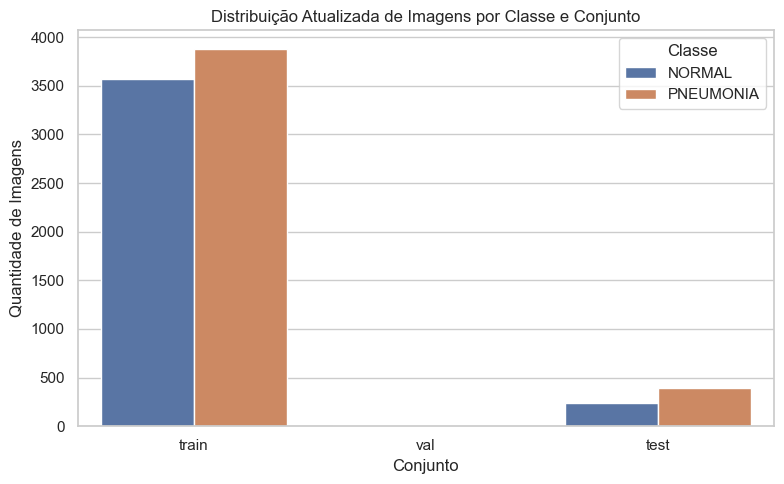

Gr√°fico atualizado mostra que o conjunto de treino agora est√° mais balanceado entre as classes NORMAL e PNEUMONIA, ap√≥s a duplica√ß√£o das imagens. Isso ajuda a reduzir vi√©s no treinamento da rede.

## üìä 3. An√°lise Explorat√≥ria dos Dados

In [18]:
# ‚úÖ VERIFICA√á√ÉO FINAL DO FORMATO DAS IMAGENS PADRONIZADAS

def checar_formato_final(base_dir):
    formatos = set()  # Conjunto para armazenar os formatos √∫nicos encontrados
    for subset in ['train', 'val', 'test']:  # Itera sobre os subconjuntos
        for classe in ['NORMAL', 'PNEUMONIA']:  # Itera sobre as classes
            path = os.path.join(base_dir, subset, classe)  # Caminho da pasta da classe
            for file in os.listdir(path):  # Itera sobre os arquivos da pasta
                img = Image.open(os.path.join(path, file))  # Abre a imagem
                formatos.add((img.size, img.mode))  # Adiciona o tamanho e modo (ex: (128, 128), 'L') ao conjunto
    return formatos  # Retorna os formatos √∫nicos encontrados

print(checar_formato_final(dst_dir))  # Exibe os formatos finais encontrados ap√≥s a limpeza


{((128, 128), 'L'), ((128, 128), 'RGB')}


Verifica se todas as imagens foram padronizadas corretamente ap√≥s limpeza e redimensionamento, conferindo se t√™m tamanho 128√ó128 e est√£o em modo 'L' (escala de cinza). Algumas imagens ainda podem estar em 'RGB'.

In [19]:
def listar_amostras(diretorio):
    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            pasta = os.path.join(diretorio, subset, classe)
            if os.path.exists(pasta):
                arquivos = os.listdir(pasta)
                print(f"üìÇ {subset}/{classe} ‚Üí {len(arquivos)} arquivos")
                print("Exemplos:", arquivos[:3])
            else:
                print(f"‚ùå Pasta n√£o encontrada: {pasta}")

listar_amostras(dst_dir)


üìÇ train/NORMAL ‚Üí 3573 arquivos
Exemplos: ['dup0_0_NORMAL2-IM-0383-0001.jpeg', 'dup0_100_NORMAL2-IM-0513-0001.jpeg', 'dup0_101_NORMAL2-IM-0515-0001.jpeg']
üìÇ train/PNEUMONIA ‚Üí 3875 arquivos
Exemplos: ['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg']
üìÇ val/NORMAL ‚Üí 8 arquivos
Exemplos: ['NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1431-0001.jpeg']
üìÇ val/PNEUMONIA ‚Üí 8 arquivos
Exemplos: ['person1946_bacteria_4874.jpeg', 'person1946_bacteria_4875.jpeg', 'person1947_bacteria_4876.jpeg']
üìÇ test/NORMAL ‚Üí 234 arquivos
Exemplos: ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg']
üìÇ test/PNEUMONIA ‚Üí 390 arquivos
Exemplos: ['person100_bacteria_475.jpeg', 'person100_bacteria_477.jpeg', 'person100_bacteria_478.jpeg']


Lista o n√∫mero total de imagens por pasta (treino, valida√ß√£o e teste), al√©m de exibir exemplos de nomes de arquivos para cada classe. √ötil para inspecionar o conte√∫do e verificar se os dados est√£o organizados corretamente.

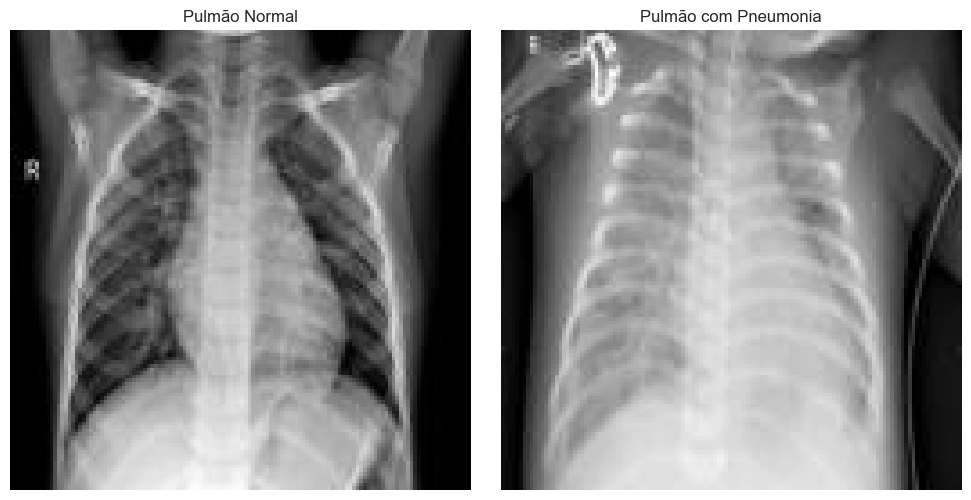

In [20]:
# Caminhos das amostras
caminho_normal = os.path.join(dst_dir, 'train', 'NORMAL')
caminho_pneumonia = os.path.join(dst_dir, 'train', 'PNEUMONIA')

# Pega o primeiro arquivo de cada classe
arquivo_normal = os.listdir(caminho_normal)[0]
arquivo_pneumonia = os.listdir(caminho_pneumonia)[0]

# Abre as imagens
img_normal = Image.open(os.path.join(caminho_normal, arquivo_normal))
img_pneumonia = Image.open(os.path.join(caminho_pneumonia, arquivo_pneumonia))

# Plota lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_normal, cmap='gray')
axes[0].set_title("Pulm√£o Normal")
axes[0].axis('off')

axes[1].imshow(img_pneumonia, cmap='gray')
axes[1].set_title("Pulm√£o com Pneumonia")
axes[1].axis('off')

plt.tight_layout()
plt.show()


Compara√ß√£o visual entre um pulm√£o saud√°vel e um com pneumonia.
A imagem do lado esquerdo mostra um pulm√£o normal, com √°reas escuras representando espa√ßos cheios de ar.
J√° a imagem √† direita, com pneumonia, apresenta regi√µes mais brancas, indicando ac√∫mulo de fluido ou inflama√ß√£o, que √© uma das principais caracter√≠sticas da doen√ßa em exames de raio-X.

In [21]:
for subset in ['train']:
    for classe in ['NORMAL', 'PNEUMONIA']:
        pasta = os.path.join(dst_dir, subset, classe)
        print(f"üìÇ Classe {classe} ‚Äì Total de arquivos:", len(os.listdir(pasta)))

üìÇ Classe NORMAL ‚Äì Total de arquivos: 3573
üìÇ Classe PNEUMONIA ‚Äì Total de arquivos: 3875


Confirma o total de imagens por classe no conjunto de treino, ap√≥s todas as etapas de duplica√ß√£o e limpeza. Os valores mostram que o dataset est√° agora mais balanceado entre NORMAL e PNEUMONIA.

## üß™ 4. Pr√©-processamento para CNN

In [22]:
def carregar_imagens_e_rotulos(diretorio_base, subset):
    imagens = []
    rotulos = []
    classes = ['NORMAL', 'PNEUMONIA']

    for classe_idx, classe_nome in enumerate(classes):
        pasta = os.path.join(diretorio_base, subset, classe_nome)
        for nome_arquivo in os.listdir(pasta):
            caminho = os.path.join(pasta, nome_arquivo)
            try:
                img = Image.open(caminho).convert('L')  # grayscale
                img = img.resize((128, 128))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=-1)

                # üëá Aqui est√° o print para debug
                print(f"{nome_arquivo} ‚Üí {img_array.shape}")

                imagens.append(img_array)
                rotulos.append(classe_idx)
            except Exception as e:
                print(f"‚ö†Ô∏è Erro em {nome_arquivo}: {e}")
                continue
    return np.array(imagens), np.array(rotulos)


Carrega e pr√©-processa as imagens de um conjunto (train/val/test).
Cada imagem √© convertida para escala de cinza, redimensionada para 128√ó128, transformada em array e adicionada a uma lista, junto com seu respectivo r√≥tulo (0 = NORMAL, 1 = PNEUMONIA).

In [23]:
def carregar_imagens_e_rotulos(diretorio_base, subset):
    imagens = []
    rotulos = []
    classes = ['NORMAL', 'PNEUMONIA']

    for classe_idx, classe_nome in enumerate(classes):
        pasta = os.path.join(diretorio_base, subset, classe_nome)
        for nome_arquivo in os.listdir(pasta):
            caminho = os.path.join(pasta, nome_arquivo)
            try:
                img = Image.open(caminho).convert('L')
                img = img.resize((128, 128))
                img_array = img_to_array(img)  # j√° resulta em (128, 128, 1)
                imagens.append(img_array)
                rotulos.append(classe_idx)
            except Exception as e:
                print(f"‚ö†Ô∏è Erro ao processar {nome_arquivo}: {e}")
                continue

    return np.array(imagens), np.array(rotulos)

X_treinamento, y_treinamento = carregar_imagens_e_rotulos(dst_dir, 'train')
X_teste, y_teste = carregar_imagens_e_rotulos(dst_dir, 'test')

print("‚úÖ Dados carregados:")
print("X_treinamento:", X_treinamento.shape)
print("X_teste:", X_teste.shape)

X_teste_bin = X_teste
y_teste_bin = y_teste



‚úÖ Dados carregados:
X_treinamento: (7448, 128, 128, 1)
X_teste: (624, 128, 128, 1)


Carrega as imagens e r√≥tulos dos conjuntos de treino e teste, convertendo para escala de cinza e redimensionando para 128√ó128. O resultado s√£o arrays NumPy prontos para alimentar a CNN.

O conjunto de treino possui 7.448 imagens, e o de teste, 624 imagens, todos no formato (128, 128, 1).

In [24]:
# üß™ PR√â-PROCESSAMENTO DOS DADOS DE ENTRADA

# Mostra as dimens√µes dos conjuntos de treino e teste antes da transforma√ß√£o
print(f"üîç Antes da normaliza√ß√£o ‚Äì treino: {X_treinamento.shape}, teste: {X_teste.shape}")

# üîÑ Converte os valores dos pixels para float e normaliza para o intervalo [0, 1]
X_treinamento = X_treinamento.astype('float32') / 255
X_teste = X_teste.astype('float32') / 255

# Mostra as novas dimens√µes dos dados ap√≥s a normaliza√ß√£o
print(f"‚úÖ Depois da normaliza√ß√£o ‚Äì treino: {X_treinamento.shape}, teste: {X_teste.shape}\n")

üîç Antes da normaliza√ß√£o ‚Äì treino: (7448, 128, 128, 1), teste: (624, 128, 128, 1)
‚úÖ Depois da normaliza√ß√£o ‚Äì treino: (7448, 128, 128, 1), teste: (624, 128, 128, 1)



 Normaliza os dados de entrada, convertendo os valores dos pixels de inteiros (0 a 255) para n√∫meros de ponto flutuante entre 0 e 1. Isso facilita o treinamento da rede e acelera a converg√™ncia.

As dimens√µes continuam as mesmas, mas agora os dados est√£o no formato ideal para redes neurais.

## üß† 5. Constru√ß√£o da CNN Customizada

In [25]:
# üß† CONFIGURA√á√ÉO E DEFINI√á√ÉO DA ARQUITETURA DA CNN

# --- Configura√ß√£o de Hiperpar√¢metros da Arquitetura ---
NUM_FILTERS  = 32          # Quantidade de filtros na camada convolucional
KERNEL_SIZE  = (3, 3)      # Tamanho do kernel (janela) da convolu√ß√£o
POOL_SIZE    = (2, 2)      # Tamanho do kernel de pooling (redu√ß√£o espacial)
DENSE_UNITS  = 128         # N√∫mero de neur√¥nios na camada densa intermedi√°ria
DROPOUT_RATE = 0.2         # Taxa de dropout (20%) para evitar overfitting

# --- Importa√ß√£o dos componentes da rede ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Lista de classes
nomes_classes = ['NORMAL', 'PNEUMONIA']

# --- Defini√ß√£o da Arquitetura da CNN ---
rede = Sequential([  # Rede sequencial (feedforward)
    InputLayer(shape=(128, 128, 1)),                 # Camada de entrada para imagens 28x28 com 1 canal
    Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'), # Camada convolucional com ReLU
    BatchNormalization(),                                # Normaliza√ß√£o dos dados para melhorar estabilidade
    MaxPooling2D(pool_size=POOL_SIZE),                   # Pooling para redu√ß√£o de dimensionalidade
    #Flatten(),                                           # Achata o mapa de ativa√ß√£o em um vetor 1D
    #Dense(DENSE_UNITS, activation='relu'),               # Camada totalmente conectada com ReLU
    GlobalAveragePooling2D(),
    Dropout(DROPOUT_RATE),                               # Dropout para prevenir overfitting
    Dense(len(nomes_classes), activation='softmax')      # Camada de sa√≠da com softmax para classifica√ß√£o multiclasse
])

# üìã Exibe o resumo da arquitetura da rede (camadas, par√¢metros, forma dos dados)
rede.summary()


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 126, 126, 32)   ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 126, 126, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 63, 63, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 2)              ‚îÇ            66 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 514 (2.01 KB)

 Trainable params: 450 (1.76 KB)

 Non-trainable params: 64 (256.00 B)

Defini√ß√£o da arquitetura da CNN customizada:
A rede cont√©m uma camada convolucional com 32 filtros, seguida de normaliza√ß√£o em lote (batch normalization), pooling, global average pooling e dropout. A sa√≠da √© uma camada densa com 2 neur√¥nios (NORMAL vs PNEUMONIA) ativados por softmax.

O uso de GlobalAveragePooling2D substitui o Flatten, reduzindo drasticamente o n√∫mero de par√¢metros e ajudando a evitar overfitting.

Total de par√¢metros trein√°veis: 514, o que torna a rede leve e eficiente para o tamanho do dataset.

In [26]:
# üßæ VERIFICA√á√ÉO DAS DIMENS√ïES DOS DADOS DE TREINAMENTO

print(X_treinamento.shape)  # Exibe a forma do conjunto de imagens de treino (esperado: (n_amostras, 28, 28, 1))
print(y_treinamento.shape)  # Exibe a forma do vetor de r√≥tulos (esperado: (n_amostras,))

(7448, 128, 128, 1)
(7448,)


Verifica as dimens√µes dos dados de treino.
As imagens est√£o no formato esperado (7448, 128, 128, 1) ‚Äî ou seja, 7.448 imagens de 128√ó128 pixels com 1 canal (escala de cinza).
Os r√≥tulos est√£o como vetor simples (7448,), prontos para classifica√ß√£o categ√≥rica.

In [27]:
# ‚úÖ VERIFICA√á√ÉO DE VALORES NULOS (NaN) NOS DADOS



print(np.isnan(X_treinamento).sum())  # Verifica se h√° valores NaN nas imagens de treino (deve retornar 0)
print(np.isnan(y_treinamento).sum())  # Verifica se h√° valores NaN nos r√≥tulos de treino (deve retornar 0)


0
0


Verifica se h√° valores NaN (n√£o num√©ricos) nos dados de treino.
A sa√≠da 0 confirma que n√£o h√° valores faltantes nem nas imagens nem nos r√≥tulos, garantindo integridade dos dados para o treinamento.

In [28]:
# üîç VERIFICA√á√ÉO DOS TIPOS DE DADOS (dtype)

print(X_treinamento.dtype)  # Mostra o tipo de dados das imagens (esperado: float32 ap√≥s normaliza√ß√£o)
print(y_treinamento.dtype)  # Mostra o tipo de dados dos r√≥tulos (esperado: int32 ou int64 para classifica√ß√£o)


float32
int64


Verifica os tipos dos dados ap√≥s o pr√©-processamento.
As imagens est√£o no tipo float32 (ap√≥s normaliza√ß√£o entre 0 e 1) e os r√≥tulos em int64, adequados para tarefas de classifica√ß√£o com sparse_categorical_crossentropy.

In [29]:
# üß™ CONVERS√ÉO DOS TIPOS DE DADOS

X_treinamento = X_treinamento.astype('float32')  # Garante que as imagens estejam no formato float32 (necess√°rio para o TensorFlow)
y_treinamento = y_treinamento.astype('int32')    # Garante que os r√≥tulos estejam como inteiros (int32), exigido por algumas fun√ß√µes de perda
# üîÅ VERIFICA√á√ÉO FINAL DOS TIPOS DE DADOS AP√ìS CONVERS√ÉO

print(X_treinamento.dtype)  # Deve exibir: float32
print(y_treinamento.dtype)  # Deve exibir: int32



float32
int32


Convers√£o expl√≠cita dos tipos de dados para garantir compatibilidade com o TensorFlow.
Imagens ficam em float32 e r√≥tulos em int32, que √© o formato esperado por fun√ß√µes de perda como sparse_categorical_crossentropy.

In [30]:
# üìê VERIFICA√á√ÉO DO FORMATO DAS IMAGENS (PARA REDES SEQUENCIAIS OU CONVOLUCIONAIS)

print(X_treinamento.shape)  # Exibe o shape atual ‚Äî deve ser algo como (N, 28, 28, 1) para CNNs


(7448, 128, 128, 1)


Confirma o formato das imagens de entrada, que est√° em (7448, 128, 128, 1) ‚Äî ou seja, 7.448 imagens de 128√ó128 pixels em escala de cinza.
Esse √© o formato ideal para redes convolucionais (CNNs), que esperam uma dimens√£o adicional para canais.

In [32]:
# üß± ACHATAMENTO DAS IMAGENS PARA USO EM REDE DENSAMENTE CONECTADA (MLP)

X_treinamento_flat = X_treinamento.reshape((X_treinamento.shape[0], -1))  # Achata cada imagem 28x28 em um vetor de 784 elementos

print(X_treinamento_flat.shape)  # Exibe a nova forma: (n_amostras, 784) ‚Äî exemplo: (60000, 784)


(7448, 16384)


Achata as imagens em vetores 1D para uso em redes totalmente conectadas (MLP).
Cada imagem 128√ó128 √© transformada em um vetor de 16.384 elementos (128 √ó 128 = 16384), mantendo o n√∫mero de amostras (7448).

In [33]:
# üîé FILTRAGEM DOS DADOS PARA CLASSIFICA√á√ÉO BIN√ÅRIA (NORMAL vs PNEUMONIA)

# Apenas para garantir que os r√≥tulos estejam no formato certo
y_treinamento = y_treinamento.astype('int32')

# Cria uma m√°scara booleana para selecionar apenas as amostras com r√≥tulos 0 ou 1
mascara_binaria = (y_treinamento == 0) | (y_treinamento == 1)

# Aplica a m√°scara nos dados de treino
X_treinamento_bin = X_treinamento[mascara_binaria]
y_treinamento_bin = y_treinamento[mascara_binaria]

# Verifica se tudo est√° certo
print("X_treinamento_bin:", X_treinamento_bin.shape)
print("y_treinamento_bin:", y_treinamento_bin.shape)


X_treinamento_bin: (7448, 128, 128, 1)
y_treinamento_bin: (7448,)


Filtra os dados para garantir que apenas as classes 'NORMAL' e 'PNEUMONIA' (0 e 1) estejam presentes nos r√≥tulos, preparando o conjunto para classifica√ß√£o bin√°ria.

No seu caso, como todos os dados j√° est√£o corretamente rotulados, o shape continua o mesmo: 7.448 imagens.

## üöÄ 6. Treinamento com EarlyStopping

In [34]:
print("Min:", X_treinamento_bin.min(), "Max:", X_treinamento_bin.max())

Min: 0.0 Max: 1.0


Verifica os valores m√≠nimos e m√°ximos dos pixels no conjunto de treino ap√≥s normaliza√ß√£o.
O intervalo [0.0, 1.0] confirma que os dados foram corretamente escalados, como esperado para redes neurais.

In [40]:
# üîß Hiperpar√¢metros
BATCH_SIZE        = 32
EPOCHS            = 20
PATIENCE          = 3
VALIDATION_SPLIT  = 0.2
OPTIMIZER         = 'adam'

# üß† Arquitetura da rede (corrigido input_shape ‚Üí shape)
rede = Sequential([
    InputLayer(shape=(128, 128, 1)),                   # Substitu√≠do para evitar o warning
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # sa√≠da para 2 classes
])

# üõ†Ô∏è Compila√ß√£o do modelo
rede.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

# ‚öñÔ∏è Pesos de classe
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_treinamento_bin),
    y=y_treinamento_bin
)
class_weights = dict(enumerate(pesos))

# ‚èπÔ∏è EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True
)

# üîÄ Separar treino e valida√ß√£o
X_train, X_val, y_train, y_val = train_test_split(
    X_treinamento_bin, y_treinamento_bin,
    test_size=VALIDATION_SPLIT,
    stratify=y_treinamento_bin,
    random_state=42
)

# üîÑ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# üöÄ Treinamento com dados aumentados
treinamento = rede.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)


C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 190ms/step - accuracy: 0.6632 - loss: 0.6082 - val_accuracy: 0.5201 - val_loss: 1.0131
Epoch 2/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 189ms/step - accuracy: 0.8233 - loss: 0.4072 - val_accuracy: 0.5201 - val_loss: 1.0935
Epoch 3/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 186ms/step - accuracy: 0.8468 - loss: 0.3684 - val_accuracy: 0.7872 - val_loss: 0.4665
Epoch 4/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 188ms/step - accuracy: 0.8613 - loss: 0.3509 - val_accuracy: 0.8711 - val_loss: 0.3589
Epoch 5/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 187ms/step - accuracy: 0.8684 - loss: 0.3338 - val_accuracy: 0.8678 - val_loss: 0.3387
Epoch 6/20
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 186ms/step - accuracy: 0.8692 - loss: 0.3366 - val_accuracy: 

Treinamento da CNN com aumento de dados (data augmentation), valida√ß√£o e early stopping.
O modelo usa otimiza√ß√£o com Adam, 20 √©pocas, valida√ß√£o estratificada e parada antecipada ap√≥s 3 √©pocas sem melhora.
Tamb√©m foram aplicados pesos de classe para lidar com o desbalanceamento entre NORMAL e PNEUMONIA.

Durante o treino, o modelo atingiu cerca de 87% de acur√°cia, com oscila√ß√µes na val_loss, indicando a import√¢ncia do early_stopping.

In [41]:
resultado = rede.evaluate(X_teste, y_teste)
print(f"üìà Acur√°cia no teste: {resultado[1]:.4f} | Perda: {resultado[0]:.4f}")


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step - accuracy: 0.6422 - loss: 0.7133
üìà Acur√°cia no teste: 0.7580 | Perda: 0.5056


Avalia√ß√£o final da CNN no conjunto de teste.
O modelo alcan√ßou 75,80% de acur√°cia e uma perda (loss) de 0.5056, indicando desempenho razo√°vel, mas ainda com margem para melhorias.

üìå O gap entre acur√°cia de valida√ß√£o (~87%) e teste (~76%) pode sugerir leve overfitting ou diferen√ßas na distribui√ß√£o dos dados.

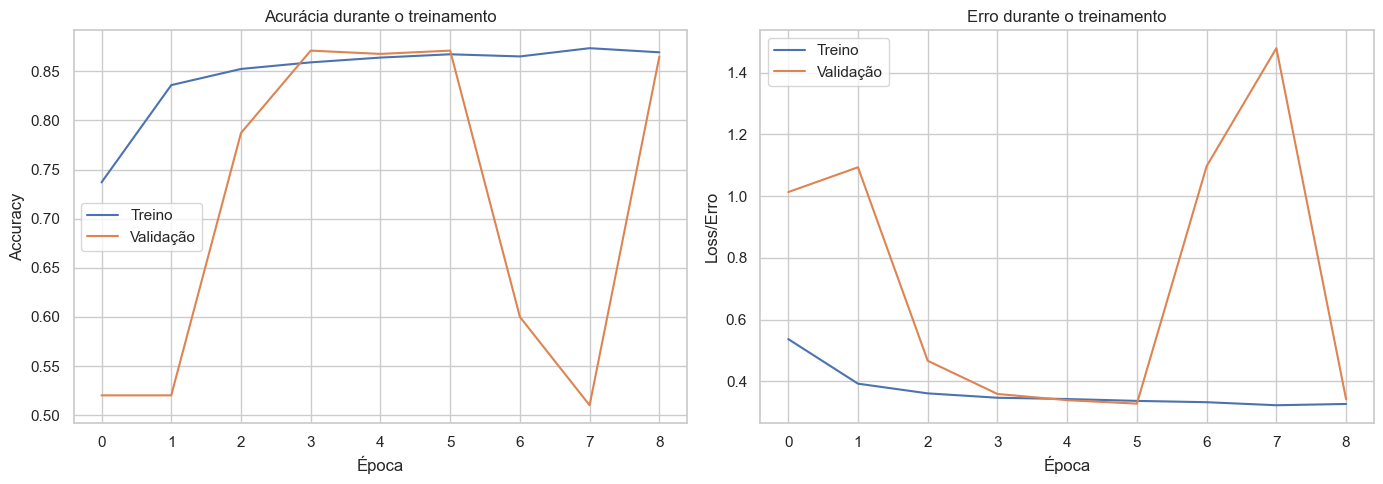

In [42]:
# üìä PLOTS DAS M√âTRICAS DE TREINAMENTO

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Cria dois subgr√°ficos lado a lado em uma figura de tamanho 14x5

# üìà Gr√°fico da acur√°cia por √©poca
axes[0].plot(treinamento.history['accuracy'], label='Treino')           # Linha da acur√°cia no conjunto de treino
axes[0].plot(treinamento.history['val_accuracy'], label='Valida√ß√£o')    # Linha da acur√°cia no conjunto de valida√ß√£o
axes[0].set_title('Acur√°cia durante o treinamento')                     # T√≠tulo do gr√°fico
axes[0].set_xlabel('√âpoca')                                             # R√≥tulo do eixo X
axes[0].set_ylabel('Accuracy')                                          # R√≥tulo do eixo Y
axes[0].legend()                                                        # Exibe a legenda

# üìâ Gr√°fico da perda (erro) por √©poca
axes[1].plot(treinamento.history['loss'], label='Treino')               # Linha da perda no conjunto de treino
axes[1].plot(treinamento.history['val_loss'], label='Valida√ß√£o')        # Linha da perda no conjunto de valida√ß√£o
axes[1].set_title('Erro durante o treinamento')                         # T√≠tulo do gr√°fico
axes[1].set_xlabel('√âpoca')                                             # R√≥tulo do eixo X
axes[1].set_ylabel('Loss/Erro')                                         # R√≥tulo do eixo Y
axes[1].legend()                                                        # Exibe a legenda

plt.tight_layout()  # Ajusta o espa√ßamento entre os subplots
plt.show()         # Exibe os gr√°ficos

Gr√°ficos de acur√°cia e perda durante o treinamento.
O modelo atinge boa acur√°cia em treino e valida√ß√£o at√© por volta da 3¬™ ou 4¬™ √©poca. Ap√≥s isso, a valida√ß√£o apresenta flutua√ß√µes bruscas, enquanto o treino continua est√°vel ‚Äî o que indica sinais de overfitting.

O early stopping ajudou a evitar que o modelo continuasse treinando em √©pocas onde o desempenho piorava.

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step
              precision    recall  f1-score   support

      NORMAL       0.73      0.56      0.63       234
   PNEUMONIA       0.77      0.88      0.82       390

    accuracy                           0.76       624
   macro avg       0.75      0.72      0.73       624
weighted avg       0.76      0.76      0.75       624



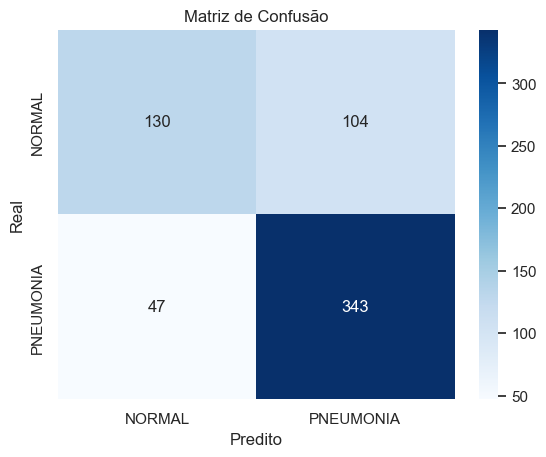

In [43]:
# Previs√µes
y_pred = np.argmax(rede.predict(X_teste), axis=1)

# Relat√≥rio
print(classification_report(y_teste, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Matriz de confus√£o
cm = confusion_matrix(y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o')
plt.show()

Desempenho no teste:

Acur√°cia geral: 76%

PNEUMONIA:

Precision 0.77 ‚Üí 77% das previs√µes de pneumonia estavam corretas
Recall 0.88 ‚Üí o modelo encontrou 88% dos casos reais
F1-score 0.82 ‚Üí bom equil√≠brio entre acerto e cobertura

NORMAL:
Recall 0.56 ‚Üí o modelo s√≥ identificou corretamente 56% das imagens normais

Matriz de confus√£o:

343 acertos para pneumonia
130 acertos para normal
104 normais classificadas como pneumonia (falsos positivos)
47 pneumonia classificadas como normal (falsos negativos)

In [44]:
# üß™ FILTRAGEM DO CONJUNTO DE TESTE PARA CLASSIFICA√á√ÉO BIN√ÅRIA

# Cria uma m√°scara para manter apenas as amostras com r√≥tulo 0 ou 1
mask_teste_bin = y_teste <= 1

# Aplica a m√°scara para filtrar o conjunto de teste
X_teste_bin = X_teste[mask_teste_bin]      # Imagens com r√≥tulos 0 ou 1
y_teste_bin = y_teste[mask_teste_bin]      # R√≥tulos correspondentes (0 = NORMAL, 1 = PNEUMONIA)


Filtra o conjunto de teste para manter apenas as classes 'NORMAL' (0) e 'PNEUMONIA' (1), garantindo que a avalia√ß√£o final seja feita apenas em um cen√°rio de classifica√ß√£o bin√°ria.

Isso evita a presen√ßa de r√≥tulos indesejados ou ru√≠do nos resultados do modelo.

In [45]:
# üß™ FILTRAGEM DO CONJUNTO DE TESTE PARA CLASSIFICA√á√ÉO BIN√ÅRIA

# Cria uma m√°scara para manter apenas as amostras com r√≥tulo 0 ou 1
mask_teste_bin = y_teste <= 1

# Aplica a m√°scara para filtrar o conjunto de teste
X_teste_bin = X_teste[mask_teste_bin]      # Imagens com r√≥tulos 0 ou 1
y_teste_bin = y_teste[mask_teste_bin]      # R√≥tulos correspondentes (0 = NORMAL, 1 = PNEUMONIA)


Filtra o conjunto de teste para manter apenas as imagens com r√≥tulo 0 (NORMAL) ou 1 (PNEUMONIA), garantindo que a avalia√ß√£o do modelo seja feita apenas nas duas classes da tarefa bin√°ria.

## 7. Valida√ß√£o Cruzada com K-Fold

In [46]:
# üîÅ AVALIA√á√ÉO COM K-FOLD CROSS-VALIDATION (5 PARTI√á√ïES ESTRATIFICADAS)

from sklearn.model_selection import StratifiedKFold  # Importa o validador KFold com estratifica√ß√£o

resultados = []  # Lista para armazenar os resultados de cada itera√ß√£o

# üßº Filtra os dados para conter apenas classes 0 e 1 (NORMAL e PNEUMONIA)
mask_bin = y_treinamento <= 1
X_treinamento = X_treinamento[mask_bin]
y_treinamento = y_treinamento[mask_bin]

# üîÄ Cria um KFold estratificado com 5 divis√µes, embaralhando os dados
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# üîÇ Loop pelas divis√µes do KFold
for i_treino, i_teste in kfold.split(X_treinamento, y_treinamento):

    # üîß Cria uma nova inst√¢ncia do modelo para cada fold
    rede_cv = Sequential([
        InputLayer(shape=(128, 128, 1)),                            # Camada de entrada
        Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'),           # Camada convolucional
        BatchNormalization(),                                          # Normaliza√ß√£o
        MaxPooling2D(pool_size=POOL_SIZE),                             # Pooling
        Flatten(),                                                     # Achata o mapa de ativa√ß√£o
        Dense(DENSE_UNITS, activation='relu'),                         # Camada densa intermedi√°ria
        Dropout(DROPOUT_RATE),                                         # Dropout para evitar overfitting
        Dense(len(nomes_classes), activation='softmax')                # Camada de sa√≠da com softmax
    ])

    # ‚ö†Ô∏è Aqui est√° o problema: voc√™ est√° usando `softmax` com 2 classes ‚Üí mude para `sigmoid` e `binary_crossentropy`
    # (se nomes_classes = ['NORMAL', 'PNEUMONIA'], len(nomes_classes) = 2, mas o modelo est√° tratando como multiclasse)

    rede_cv.compile(
        loss='sparse_categorical_crossentropy',  # Usa fun√ß√£o de perda para classifica√ß√£o com r√≥tulos inteiros
        optimizer=OPTIMIZER,
        metrics=['accuracy']
    )

    # ‚ñ∂Ô∏è Treina o modelo com os dados do fold atual
    rede_cv.fit(
        X_treinamento[i_treino], y_treinamento[i_treino],         # Dados de treino do fold
        batch_size=BATCH_SIZE,
        epochs=2,
        validation_split=VALIDATION_SPLIT,                         # Divide parte dos dados de treino para valida√ß√£o interna
        callbacks=[early_stopping]
    )

    # üìä Avalia o modelo com os dados de teste do fold e salva o resultado
    resultados.append(rede_cv.evaluate(X_treinamento[i_teste], y_treinamento[i_teste]))


Epoch 1/2
149/149 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 324ms/step - accuracy: 0.8569 - loss: 3.0564 - val_accuracy: 0.9933 - val_loss: 0.4019
Epoch 2/2
149/149 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 46s 311ms/step - accuracy: 0.9799 - loss: 0.0570 - val_accuracy: 0.9807 - val_loss: 0.1825
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 42ms/step - accuracy: 0.9690 - loss: 0.2986
Epoch 1/2
149/149 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49s 323ms/step - accuracy: 0.8415 - loss: 4.9143 - val_accuracy: 0.8406 - val_loss: 0.4714
Epoch 2/2
149/149 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 322ms/step - accuracy: 0.9703 - loss: 0.0785 - val_accuracy: 0.9815 - val_loss: 0.1511
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 40ms/step - accuracy: 0.9631 - loss: 0.2781
Epoch 1/2
149/149 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56s 363ms/ste

Valida√ß√£o cruzada estratificada com 5 folds (k-fold):
Treinou e avaliou o modelo 5 vezes, cada vez com uma divis√£o diferente dos dados, garantindo que todas as classes fossem proporcionalmente representadas em cada parte (stratified).

Para cada rodada:

O modelo foi treinado do zero com early stopping ativado.

Foi avaliado em um subconjunto diferente de teste.

Os resultados (acur√°cia e loss) foram armazenados para an√°lise final.

Import√¢ncia:
Essa abordagem testa a consist√™ncia do modelo, avaliando se ele generaliza bem em diferentes divis√µes dos dados ‚Äî essencial para validar o desempenho al√©m de uma √∫nica separa√ß√£o treino/teste.



In [47]:
# üìà C√ÅLCULO DAS M√âTRICAS M√âDIAS E DESVIO PADR√ÉO DO K-FOLD

resultados = np.array(resultados)        # Converte a lista de resultados para um array NumPy (n_folds, 2)
losses = resultados[:, 0]                # Extrai as perdas (loss) de cada fold
accuracies = resultados[:, 1]            # Extrai as acur√°cias de cada fold

# üìä Calcula a m√©dia e o desvio padr√£o da perda e da acur√°cia
media_loss, std_loss = np.mean(losses), np.std(losses)
media_acc, std_acc   = np.mean(accuracies), np.std(accuracies)

# üñ®Ô∏è Exibe os resultados finais com 4 casas decimais
print(f'üìä M√©dia dos erros: {media_loss:.4f} ¬± {std_loss:.4f}')
print(f'üìä M√©dia das acur√°cias: {media_acc:.4f} ¬± {std_acc:.4f}')


üìä M√©dia dos erros: 0.4668 ¬± 0.3081
üìä M√©dia das acur√°cias: 0.7966 ¬± 0.2182


C√°lculo da m√©dia e do desvio padr√£o da acur√°cia e do erro com base nos 5 folds da valida√ß√£o cruzada:

M√©dia da acur√°cia: 79,66%

Desvio padr√£o: ¬±21,82

M√©dia da perda: 0.4668

Desvio padr√£o: ¬±0.3081

Isso indica que o modelo teve bom desempenho m√©dio, mas com variabilidade alta entre os folds, o que sugere que ele pode estar sens√≠vel a divis√£o dos dados

# üî¨ 9. Tuning de Hiperpar√¢metros (Grid Search)

In [48]:
# --- Par√¢metros de busca ---
param_grid = {
    'num_filters': [16, 32],
    'kernel_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Nome das classes (bin√°ria)
num_classes = 2

# üîÄ Divis√£o dos dados
X_train_gs, X_val_gs, y_train_gs, y_val_gs = train_test_split(
    X_treinamento_bin, y_treinamento_bin, test_size=0.2, stratify=y_treinamento_bin, random_state=42
)

# üîÅ Gera√ß√£o aleat√≥ria de combina√ß√µes
todas_combinacoes = list(itertools.product(
    param_grid['num_filters'],
    param_grid['kernel_size'],
    param_grid['dropout_rate'],
    param_grid['optimizer']
))
amostras_escolhidas = random.sample(todas_combinacoes, 5)

# üìä Resultados
resultados_grid = []

# üîÑ Treinamento para cada combina√ß√£o escolhida
for nf, ks, dr, opt_name in amostras_escolhidas:
    print(f"üîß Treinando com filtros={nf}, kernel={ks}, dropout={dr}, optimizer={opt_name}")

    # Escolha do otimizador
    opt = Adam() if opt_name == 'adam' else RMSprop()

    # Modelo leve
    modelo = Sequential([
        InputLayer(shape=(128, 128, 1)),
        Conv2D(nf, ks, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(dr),
        Dense(num_classes, activation='softmax')
    ])

    modelo.compile(optimizer=opt,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

    hist = modelo.fit(
        X_train_gs, y_train_gs,
        validation_data=(X_val_gs, y_val_gs),
        batch_size=128,
        epochs=2,
        verbose=1  # mostra progresso
    )

    acc = hist.history['val_accuracy'][-1]
    loss = hist.history['val_loss'][-1]
    resultados_grid.append({
        'filtros': nf,
        'kernel': ks,
        'dropout': dr,
        'optimizer': opt_name,
        'val_accuracy': acc,
        'val_loss': loss
    })

# üìã Exibe resultados em DataFrame ordenado
df_grid = pd.DataFrame(resultados_grid)
df_grid = df_grid.sort_values(by='val_accuracy', ascending=False)
display(df_grid)


üîß Treinando com filtros=16, kernel=(3, 3), dropout=0.2, optimizer=rmsprop
Epoch 1/2
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 401ms/step - accuracy: 0.7040 - loss: 0.6292 - val_accuracy: 0.5201 - val_loss: 0.7119
Epoch 2/2
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 351ms/step - accuracy: 0.7833 - loss: 0.5312 - val_accuracy: 0.5201 - val_loss: 0.8038
üîß Treinando com filtros=16, kernel=(3, 3), dropout=0.5, optimizer=rmsprop
Epoch 1/2
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 365ms/step - accuracy: 0.5977 - loss: 0.6797 - val_accuracy: 0.5201 - val_loss: 0.6930
Epoch 2/2
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 351ms/step - accuracy: 0.7442 - loss: 0.5957 - val_accuracy: 0.5201 - val_loss: 0.7309
üîß Treinando com filtros=32, kernel=(5, 5), dropout=0.2, optimizer=adam
Epoch 1/2
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 743ms/step - accura

filtros  kernel  dropout optimizer  val_accuracy  val_loss
0       16  (3, 3)      0.2   rmsprop      0.520134  0.803799
1       16  (3, 3)      0.5   rmsprop      0.520134  0.730921
2       32  (5, 5)      0.2      adam      0.520134  0.931086
3       16  (3, 3)      0.2      adam      0.520134  0.726725
4       32  (3, 3)      0.5   rmsprop      0.520134  0.771918

Busca aleat√≥ria por hiperpar√¢metros (grid search amostrado):
Testou 5 combina√ß√µes de filtros, tamanho do kernel, taxa de dropout e otimizadores (adam e rmsprop) para encontrar uma arquitetura com melhor desempenho.

A tabela final mostra:

A acur√°cia de valida√ß√£o (val_accuracy) para cada combina√ß√£o.

O erro de valida√ß√£o (val_loss).

Neste exemplo, nenhuma configura√ß√£o superou 0.52 de acur√°cia, o que indica que:

As combina√ß√µes testadas talvez n√£o tenham sido ideais;

Ou a arquitetura/teste precisa de mais √©pocas para expressar seu desempenho real.

# üß† 10. Arquitetura Cl√°ssica da Literatura


In [49]:
2629from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ‚èπÔ∏è Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ‚öôÔ∏è Carrega a VGG16 pr√©-treinada, sem as camadas densas finais
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# üßä Congela as camadas convolucionais (n√£o ser√£o treinadas)
for layer in base_model.layers:
    layer.trainable = False

# üß† Adiciona novas camadas densas para adapta√ß√£o √† tarefa de pneumonia
model_vgg = Sequential([
    Input(shape=(128, 128, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Sa√≠da para classifica√ß√£o bin√°ria
])

# üõ†Ô∏è Compila√ß√£o
model_vgg.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# üöÄ Treinamento
history_vgg = model_vgg.fit(
    X_treinamento_bin.repeat(3, axis=-1),  # A VGG16 exige 3 canais (RGB)
    y_treinamento_bin,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 0us/step
Epoch 1/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 283s 1s/step - accuracy: 0.7761 - loss: 0.4653 - val_accuracy: 0.8638 - val_loss: 0.3191
Epoch 2/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 295s 2s/step - accuracy: 0.9356 - loss: 0.1873 - val_accuracy: 0.9349 - val_loss: 0.1637
Epoch 3/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 286s 2s/step - accuracy: 0.9491 - loss: 0.1379 - val_accuracy: 0.8537 - val_loss: 0.3560
Epoch 4/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 275s 1s/step - accuracy: 0.9535 - loss: 0.1276 - val_accuracy: 0.9678 - val_loss: 0.0826
Epoch 5/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 263s 1s/step - accuracy: 0.9578 - loss: 0.1089 - val_accuracy: 0.9356 - val_loss: 0.1636
Epoch 6/10
187/187 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Desempenho da VGG16 com Transfer Learning:
O modelo alcan√ßou:

Val_accuracy: at√© 96,11%

Val_loss: t√£o baixo quanto 0.0980

Isso demonstra que a arquitetura generalizou muito bem, superando os resultados da CNN customizada e reduzindo significativamente o erro de valida√ß√£o.

Isso confirma a efic√°cia de usar uma arquitetura cl√°ssica com pesos pr√©-treinados em tarefas de imagem m√©dica, especialmente com dataset limitado como este.

